# Домашнее задание
## Реализация алгоритма Deep Feature Interpolation

### План

1. Изучите алгоритм, описанный в [статье](https://arxiv.org/pdf/1611.05507.pdf).
2. Скачайте датасет (`faces.tar`) и разархивируйте его.
3. Реализуйте алгоритм **Deep Feature Interpolation**.
4. Продемонстрируйте результаты работы на произвольном изображении.

### Критерии оценки

* реализация базового алгоритма (с демонстрацией работы на каком-нибудь изображении из выборки): **50 баллов**
* визуализация интерполяции (варьировать степень модификации изменением $\alpha$): **30 баллов**
* применить алгоритм к какой-нибудь картике не из выборки (с применением детектора и вставкой обратно): **20 баллов**

### Подсказки

* для экономии памяти предлагается хранить в индексе не сами вектора, а их проекции на меньшее пространство (например, в качестве базиса использовать top-256 PCA, посчитанный на 5К-10К объектах выборки), а когда нужно посчитать вектор-смещение, просто пересчитывать необходимое количество
* поэкспериментируйте со взвешиванием основного лосса и полной вариации
* экспериментируйте на изображениях меньшего разрешения (например, 64х64)

In [1]:
from PIL import Image
import numpy as np
import os
from sklearn.decomposition import PCA

import torch
from tensorflow import convert_to_tensor
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm_notebook
import pickle
from sklearn.decomposition import PCA

from scipy.spatial.distance import cosine

IMAGE_SIZE = 128

In [2]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

### Загрузка данных

*Предоставляемый датасет был размечен классификатором, поэтому может содержать большое количество ошибок. Тем не менее, для выполнения данного задания это не так критично.*

In [3]:
def load_dataset(directory):
    header = []
    labels = []
    filepaths = []
    
    with open(os.path.join(directory, 'gt.csv')) as f:
        header = f.readline().strip().split()[1:]
        header = [h.lower() for h in header]
        for line in f:
            fields = line.strip().split()
            path = os.path.join(directory, fields[0])
            filepaths.append(path)
            labels.append(fields[1:])

    return (
        header,
        np.array(labels),
        np.array(filepaths)
    )

DATASET_DIRECTORY_PATH = './data/faces'  
header, labels, filepaths = load_dataset(DATASET_DIRECTORY_PATH)

print(f"{len(filepaths)} изображений в датасете")

202278 изображений в датасете


In [4]:
print("Содержимое датасета по категориям:")
for i in range(len(header)):
    print(header[i], ":")
    names, counts = np.unique(labels[:, i], return_counts=True)
    for j in range(len(names)):
        print(" * ", names[j], ":", counts[j])

Содержимое датасета по категориям:
race :
 *  asian : 16215
 *  caucasian : 186063
gender :
 *  female : 134736
 *  male : 67542
age :
 *  adult : 75318
 *  old : 62429
 *  senior : 43973
 *  young : 20558
facial_hair :
 *  beard : 6689
 *  mustache : 2541
 *  shaved : 193048


In [5]:
# функция для удобного взаимодействия с разметкой

def get_mask(**kwargs):
    mask = np.ones(len(filepaths), dtype=np.bool)
    for h in kwargs:
        if isinstance(kwargs[h], list):
            mask &= np.in1d(labels[:, header.index(h)], kwargs[h])
        else:
            mask &= labels[:, header.index(h)] == kwargs[h]
    return mask

def load_image(path, size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = Image.open(path)
    img = img.convert("RGB")
    img = img.resize(size, Image.BICUBIC)
    return img

# примеры запросов
print("count(asian & female) =", get_mask(race='asian', gender='female').sum())
print("count(caucasian & male & shaved) =", get_mask(race='caucasian', gender='male', facial_hair='shaved').sum())

count(asian & female) = 11046
count(caucasian & male & shaved) = 53359


### Функция $\phi(x)$

Определим функцию отображения в признаковое пространство в виде `nn.Module`:


In [6]:
class Phi(nn.Module):
    def __init__(self, pretrained=True):
        super(Phi, self).__init__()

        model = torchvision.models.vgg19(pretrained=pretrained)
        layers = list(model.features)
        self.slice_0 = nn.Sequential(*layers[0:12])
        self.slice_1 = nn.Sequential(*layers[12:21])
        self.slice_2 = nn.Sequential(*layers[21:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        mean = x.new_tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = x.new_tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        x = (x - mean) / std
        
        xs = []

        x = self.slice_0(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_1(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_2(x)
        xs.append(x.view(x.shape[0], -1))
        
        return torch.cat(xs, 1)
    

to_tensor = torchvision.transforms.ToTensor()
to_image = torchvision.transforms.ToPILImage()

phi = Phi()

number of features per image:  425984


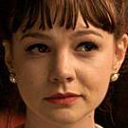

In [7]:
# пример использования

image = load_image(filepaths[0])
fx = phi(to_tensor(image).unsqueeze(0))[0]

print("number of features per image: ", fx.shape[0])
image

### Построение индекса базы

Извлеките признаки (функцией $\phi$) из изображений базы. По этим признакам вы будете искать похожие изображения, поэтому можно хранить их сжатое представление.

In [8]:
image_features = []
train_paths = filepaths[np.random.choice(202278, 2000)]

for i in tqdm_notebook(range(2000)):
    cur_image = load_image(train_paths[i])
    image_features.append(phi(to_tensor(cur_image).unsqueeze(0))[0])


In [9]:
image_features = np.array(image_features)
pca = PCA(n_components=256)
pca.fit(image_features)

PCA(copy=True, iterated_power='auto', n_components=256, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Сохранение модели

In [10]:
pickle.dump(pca, open('saved_pca', 'wb'))

Загрузка обученной модели и преобразованных данных

In [8]:
pca = pickle.load(open('saved_pca', 'rb'))

In [9]:
pca_data = np.load('pca_data.npy', allow_pickle=True)

Подготовка данных

In [12]:
batch_size = 2150

pca_data = list(pca_data)
for i in tqdm_notebook(range(71, 94)):
    cur_data = []
    for j in range(2150*i, 2150*(i+1)):
        cur_image = load_image(filepaths[j])
        cur_data.append(phi(to_tensor(cur_image).unsqueeze(0))[0])
    pca_data.append(pca.transform(cur_data))
    np.array(pca_data).dump('pca_data.npy')

last_data = []
for i in range(202100, 202278):
    cur_image = load_image(filepaths[i])
    last_data.append(phi(to_tensor(cur_image).unsqueeze(0))[0])
        
pca_data.append(pca.transform(last_data))
np.array(pca_data).dump('pca_data.npy')

In [10]:
pca_reshaped = []
for i in range(95):
    pca_reshaped += list(pca_data[i])

pca_reshaped = np.array(pca_reshaped)
pca_reshaped.shape

(202278, 256)

# Функция подбора кандидатов

У нас есть база признаков, по которым мы можем искать изображения, похожие на запрос. Напишите функцию, которая для данного изображения `query` находит `n` наиболее похожих на него (по сжатому признаковому описанию) среди изображений, покрываемых бинарной маской `mask` (размер маски равен количеству изображений в базе). В качестве меры похожести можете использовать косинусную меру.

In [11]:
def get_mask_ind(mask):
    mask_ind = np.arange(202278) * mask
    mask_ind = list(mask_ind[mask_ind > 0])
    if mask[0] == 1:
        mask_ind.append(0)
    
    return np.array(mask_ind)

def best_similar(query_img, mask, n=100):
    mask_ind = get_mask_ind(mask)
    fx = phi(to_tensor(query_img).unsqueeze(0))
    query_pca = pca.transform(fx)
    distances = {}
    for i in mask_ind:
        cur_dist = cosine(query_pca, pca_reshaped[i])
        distances[i] = cur_dist
        
    distances = np.array(sorted(distances.items(), key=lambda kv: kv[1]))[:, 0]
    return distances[:n].astype(int)

In [12]:
def get_similar_img(query_img, mask, n=3):
    indexes = best_similar(query_img, mask, n)
    fig, axes = plt.subplots(nrows=1, ncols=n, sharex=True)
    j = 0
    for i in indexes:
        cur_image = load_image(filepaths[i])
        axes[j].imshow(cur_image)
        j += 1

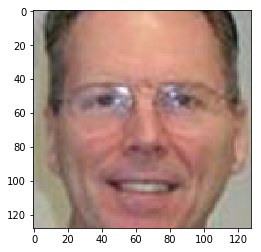

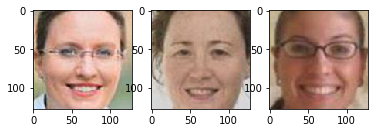

In [13]:
test_mask = get_mask(race='caucasian', gender='female')
img = load_image(filepaths[108])
plt.imshow(img)
get_similar_img(img, test_mask)

### Вычисление центров кластеров

Используя функцию `best_similar` реализуйте функцию подсчёта центров кластеров в признаковом пространстве $\phi$ изображений, наиболее похожих на изображение-запрос. С использованием этой функции вы сможете для двух различных наборов атрибутов (например `caucasian & male` и `asian & male`) вычислить вектор-смещение, по которому мы будем "двигать" признаковое описание оптимизируемого изображения. 

*Заметьте, что если мы будем производить модификацию из `caucasian & male` в `asian & male`, то изображение, которое мы оптимизируем, должно принадлежать множеству `caucasian & male`, иначе результат может получиться так себе.*

In [14]:
def get_center(query_img, mask):
    nearest_ind = best_similar(query_img, mask)
    fam = []
    for ind in nearest_ind:
        fam.append(to_tensor(load_image(filepaths[ind])).unsqueeze(0))
    
    return phi(torch.cat(fam, 0))

def count_w(query_img, mask1, mask2):
    
    return get_center(query_img, mask2) - get_center(query_img, mask1)

### Функция потерь

Реализуйте функцию потерь, которую мы будем минимизировать для выбранного изображения и вычисленного для него вектора смещения.

In [15]:
class TVLoss(nn.Module):
    def __init__(self, eps=1e-3, beta=2):
        super(TVLoss, self).__init__()
        self.eps = eps
        self.beta = beta

    def forward(self, input):
        x_diff = input[:, :, :-1, :-1] - input[:, :, :-1, 1:]
        y_diff = input[:, :, :-1, :-1] - input[:, :, 1:, :-1]

        sq_diff = torch.clamp(x_diff * x_diff + y_diff * y_diff, self.eps, 10000000)
        return torch.norm(sq_diff, self.beta / 2.0) ** (self.beta / 2.0)

### Оптимизиация

Напишите код оптимизиации изображения с использованием какого-нибудь оптимизатора.

In [17]:
def dfi_inverse(img, target):
    img = img.cuda()
    phi.cuda()
    target = target.cuda()
    recon_var = nn.Parameter(img.cuda(), requires_grad = True)
    
    optimizer = torch.optim.LBFGS(
          params = [recon_var],
          max_iter = 750,
    )
    
    criterion1 = nn.MSELoss(size_average = False).cuda()
    criterion2 = TVLoss().cuda()
    
    def step():
        optimizer.zero_grad()
        
        recon_features = phi.forward(recon_var)
        loss1 = criterion1(recon_features, target)
        loss2 = criterion2(recon_var)
        loss = loss1 + loss2
        loss.backward()
        return loss
    
    optimizer.step(step)
    
    target.cpu()
    phi.cpu()
    optimized_img = recon_var.detach().cpu()
    return optimized_img

In [22]:
def transform_img(query_img, init_mask, target_mask, alpha=3):
    phi.cpu()
    w = count_w(query_img, init_mask, target_mask)
    
    img = to_tensor(query_img).unsqueeze(0)
    query_features = phi(img)[0]
    
    dfi_res = dfi_inverse(img, query_features + alpha * w)
    odd = dfi_inverse(img, query_features)
    
    result = dfi_res + (img - odd)
    return to_image(result.data.clamp_(0, 1)[0])

In [26]:
def test1(img, **kwargs):
    female_mask = get_mask(gender='female', race='caucasian')
    male_mask = get_mask(gender='male', race='caucasian')
    
    res_img = transform_img(img, male_mask, female_mask, **kwargs)
    
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.imshow(img)
    plt.subplot(2, 2, 2)
    plt.imshow(res_img)
    
    return 

def test2(img, **kwargs):
    caucasian_mask = get_mask(gender='female', race='caucasian')
    asian_mask = get_mask(gender='female', race='asian')
    
    res_img = transform_img(img, caucasian_mask, asian_mask, **kwargs)
    
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.imshow(img)
    plt.subplot(2, 2, 2)
    plt.imshow(res_img)
    
    return 

def test3(img, **kwargs):
    shaved_mask = get_mask(gender='male', facial_hair='shaved')
    bread_mask = get_mask(gender='male', facial_hair='beard')
    
    res_img = transform_img(img, shaved_mask, bread_mask, **kwargs)
    
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.imshow(img)
    plt.subplot(2, 2, 2)
    plt.imshow(res_img)
    
    return 

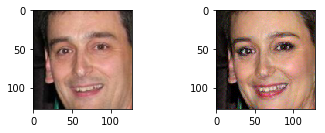

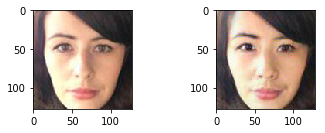

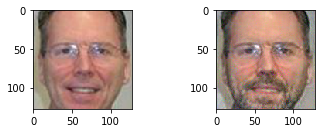

In [27]:
test1_img = load_image(filepaths[15998])
test2_img = load_image(filepaths[1800])
test3_img = load_image(filepaths[108])

test1(test1_img)
test2(test2_img)
test3(test3_img)

### Устранение артефактов (желательно)

В результате оптимизации на изображении могут появиться нежелательные артифакты в виде смещения цетовой палитры. Попробуйте побороть это вычитанием из результата разницы между исходным изображением и модифицированным изображением с параметром $\alpha=0$.

Устранение артифактов реализовано в функции `transform_image`, разница, вычитаемая из результата : `(img - odd)`

### Интерполяция в признаковом пространстве (бонус)

Постройте последовательность изображений с варьированием степени модификации.

<Figure size 1440x1440 with 0 Axes>

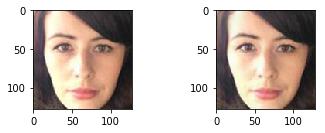

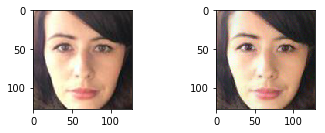

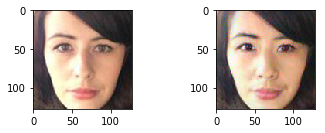

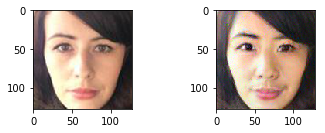

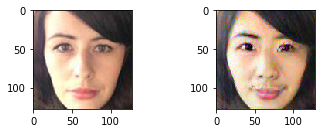

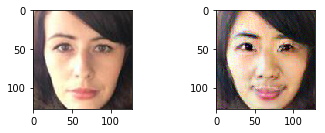

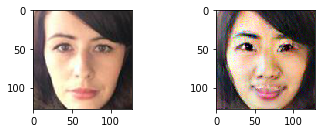

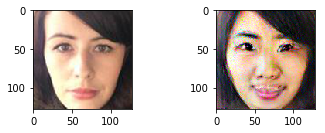

In [32]:
alpha = np.linspace(1, 8, 8)

plt.figure(figsize=(20, 20))
for i in range (8):
    test2(test2_img, alpha=alpha[i])

### Работа с изображениями не из базы (бонус)

Ниже приведена функция `get_face_bbox`, которая возращает координаты для кропа лица из изображения. Используйте её, чтобы вырезать изображение лица, произвести над ним какую-нибудь трансформацию (например, смена пола или расы), а затем вставить модифицированное изображение обратно.

In [33]:
import cv2


HAAR_CASCADE_FILEPATH = './data/haarcascade_frontalface_default.xml'
cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILEPATH)

def get_face_bbox(image):
    faces = cascade.detectMultiScale(
        np.asarray(image),
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(50, 50),
        flags=cv2.CASCADE_SCALE_IMAGE)
    if len(faces) != 1:
        return None
    x, y, w, h = faces[0]
    return x, y, x + w, y + h

In [40]:
def make_female_face(img):
    x1, y1, x2, y2 = get_face_bbox(img)
    face = img.crop((x1, y1, x2, y2))
    init_size = face.size
    face = torchvision.transforms.Resize(128)(face)
    
    female_mask = get_mask(gender='female', race='caucasian')
    male_mask = get_mask(gender='male', race='caucasian')
    female_face = transform_img(face, male_mask, female_mask)
    
    female_face = torchvision.transforms.Resize(init_size)(female_face)
    res = img.copy()
    res.paste(female_face, (x1, y1))
    return res

In [45]:
male_img = torchvision.transforms.Resize(512)(Image.open('test_mcavoy.jpg'))
female_img = make_female_face(male_img)

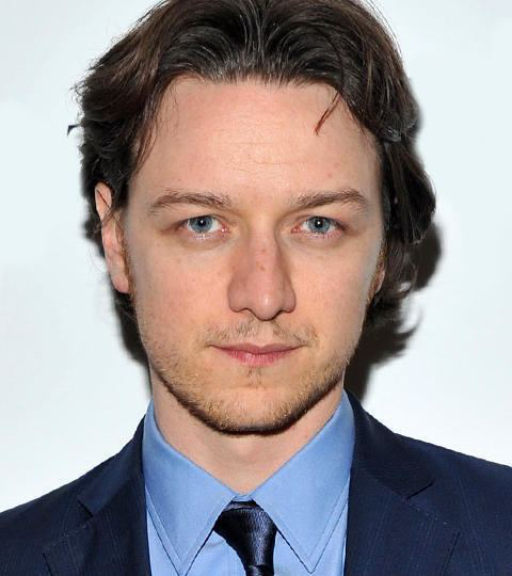

In [46]:
male_img

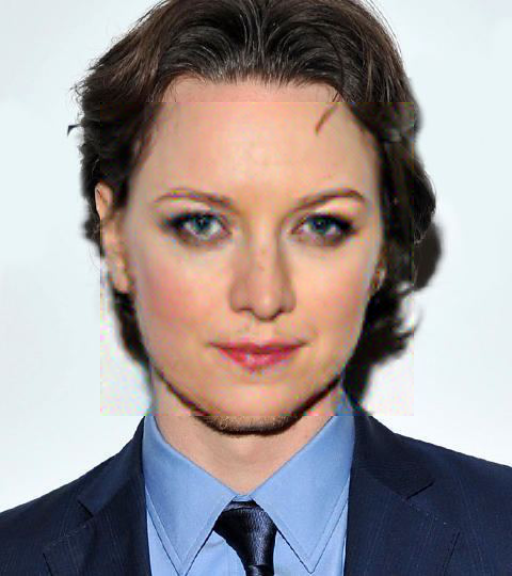

In [47]:
female_img